<a href="https://colab.research.google.com/github/Kata5/DeepLearning2021/blob/main/DeepLearning2021Milestone02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

PLease find the detailed discussion of variational autoencoders in the attached documentation

Download the CelebA dataset

In [1]:
!gdown --id 1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW

Downloading...
From: https://drive.google.com/uc?id=1uy2L1qT4kR8QWh6W0TEBqPuezMvJChgW
To: /content/img_align_celeba.zip
100% 1.44G/1.44G [00:07<00:00, 183MB/s]


In [2]:
!unzip img_align_celeba.zip -d data

A streamkimeneten csak az utolsó 5000 sor látható.
 extracting: data/img_align_celeba/197600.jpg  
 extracting: data/img_align_celeba/197601.jpg  
 extracting: data/img_align_celeba/197602.jpg  
 extracting: data/img_align_celeba/197603.jpg  
 extracting: data/img_align_celeba/197604.jpg  
 extracting: data/img_align_celeba/197605.jpg  
 extracting: data/img_align_celeba/197606.jpg  
 extracting: data/img_align_celeba/197607.jpg  
 extracting: data/img_align_celeba/197608.jpg  
 extracting: data/img_align_celeba/197609.jpg  
 extracting: data/img_align_celeba/197610.jpg  
 extracting: data/img_align_celeba/197611.jpg  
 extracting: data/img_align_celeba/197612.jpg  
 extracting: data/img_align_celeba/197613.jpg  
 extracting: data/img_align_celeba/197614.jpg  
 extracting: data/img_align_celeba/197615.jpg  
 extracting: data/img_align_celeba/197616.jpg  
 extracting: data/img_align_celeba/197617.jpg  
 extracting: data/img_align_celeba/197618.jpg  
 extracting: data/img_align_celeba/19

In [3]:
!gdown --id 1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3

Downloading...
From: https://drive.google.com/uc?id=1nDQffbFImz9mmuRdBIm9_3adOQBZ8rY3
To: /content/list_attr_celeba.csv
100% 24.9M/24.9M [00:00<00:00, 79.2MB/s]


After have some pilot projects with Tensorflow,Keras and PyTorch I decided to use the later one as it is much simpler to implement Variational Autoencoder with it.
GPU optimalisation is essentiala check is done for availability

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

import torch.optim as  optim 
if torch.cuda.is_available():  
  dev = "cuda:0" 
  print("gpu up")
else:  
  dev = "cpu"  
device = torch.device(dev)

gpu up


Reading the csv for attributes

In [5]:
df = pd.read_csv("list_attr_celeba.csv", delimiter = ';')

In [6]:
def haircolor(x):
    if x["Blond_Hair"] == 1:
        return 0
    elif x["Brown_Hair"] == 1:
        return 1
    elif x["Black_Hair"] == 1:
        return 2
    else :
        return 3
    
df["Hair_Color"] = df.apply(haircolor,axis=1)

In [7]:
"""
for simplicity I decided to make the VAE capture just for attributes 

Hair Color (blond,brown,black and neither of these(or unknown))
Pale Skin 
Gender 
Beard (in case of male)
"""

df = df[["image_id","Hair_Color",'Pale_Skin',"Male","No_Beard"]]

In [8]:
"""
replacing -1 with 0 without affecting the the 1 values 

"""
df.Pale_Skin = df.Pale_Skin.apply(lambda x: max(x,0)) 
df.Male = df.Male.apply(lambda x: max(x,0))
df.No_Beard = df.No_Beard.apply(lambda x: max(x,0))


In [9]:
df

image_id  Hair_Color  Pale_Skin  Male  No_Beard
0       000001.jpg           1          0     0         1
1       000002.jpg           1          0     0         1
2       000003.jpg           3          0     1         1
3       000004.jpg           3          0     0         1
4       000005.jpg           3          0     0         1
...            ...         ...        ...   ...       ...
202594  202595.jpg           0          0     0         1
202595  202596.jpg           0          1     1         1
202596  202597.jpg           2          0     1         1
202597  202598.jpg           2          0     0         1
202598  202599.jpg           0          1     0         1

[202599 rows x 5 columns]

In [10]:
def ceil(a,b):
    return -(-a//b)

In [11]:
faces =[]
for i in df.iloc[:20000].image_id:
    pic = Image.open("data/img_align_celeba/"+i)
    pic = pic.resize((64,64))
    pix = np.array(pic.getdata()).reshape(pic.size[0], pic.size[1], 3)
    pix = pix/255
    """
    for the images I had to use np.moveaxis to change the shape from  (64,64,3) to (3,64,64)
    without messing up the image 
    
    """
    faces.append(np.moveaxis(pix,-1,0).tolist())
    
faces = np.array(faces)

Some ideas for implementing AutoEncoders in PyTorch were used from this page and (links opening from here):
https://discuss.pytorch.org/t/autoencoders-in-pytorch/844

In [12]:
class Encoder(nn.Module):
    def __init__(self):
        
        super(Encoder,self).__init__()
        # parameters from https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html 
        # channels_in, channels_out, kernel_size, stride , padding,
        self.conv1 = nn.Conv2d(3,64,3,1,1)
        self.maxp1 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv2 = nn.Conv2d(64,64,3,1,1)
        self.maxp2 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv3 = nn.Conv2d(64,64,4,2,1)
        self.maxp3 = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.conv4 = nn.Conv2d(64,128,4,2,1)
        self.maxp4 = nn.MaxPool2d(kernel_size=2,stride=2)


    # forward fuction for Encoder    
    def forward(self,x):
        out = self.conv1(x)
        out = self.maxp1(out)
        out = F.relu(out) 
        
        out = self.conv2(out)
        out = self.maxp2(out)
        out = F.relu(out)
        
        out = self.conv3(out)
        out = self.maxp3(out)
        out = F.relu(out)
        
        out= self.conv4(out)
        out = self.maxp4(out)
        out = F.relu(out)
        
        return out.view(out.shape[0],-1)
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        
        """
        ConvTranspose2d is very similar to the convolution operation but the convolution matrix is transposed, 
        so the result is that the output grows instead of reducing(depending on the padding, stride and kernel size used). 
        Parameters are:
        # in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0
        """
        self.transconv1 = nn.ConvTranspose2d(64+ 40,64,8,4,2)
        self.transconv2 = nn.ConvTranspose2d(64,64,8,4,2)
        self.transconv3 = nn.ConvTranspose2d(64,64,4,2,1)
        self.transconv4 = nn.ConvTranspose2d(64,3,4,2,1)
        
        """
        Embedding layers were used which are a simple lookup tables that stores embeddings of a fixed dictionary and size.
        Some features were converted into a vector to get a conditional VAE
        I.e. Hair 'states' were converted into a vector of 10 weights
        
        """
        self.hairEmbedding = nn.Embedding(4,10)
        self.beardEmbedding = nn.Embedding(2,10)
        self.genderEmbedding = nn.Embedding(2,10)
        self.paleSkinEmbedding = nn.Embedding(2,10)

        
    def forward(self,x):
        """
        Here z are sampled from x (encoded image)
        and then feature vectors are concatenating to z
        """
        z = x[:,:64]
        hair = self.hairEmbedding(x[:,64].long())
        paleSkin = self.paleSkinEmbedding(x[:,65].long())
        gender = self.genderEmbedding(x[:,66].long())
        beard = self.beardEmbedding(x[:,67].long())
        
        z = torch.cat([z,hair,beard,gender,paleSkin],dim=1)
        
        # ConvTranspose2d layers were used to the increasing the dimension of the output
        
        out= self.transconv1(z.view(z.shape[0],z.shape[1],1,1))
        out = F.relu(out)
        
        out= self.transconv2(out)
        out = F.relu(out)

        out= self.transconv3(out)
        out = F.relu(out)

        out= self.transconv4(out)
        out = F.relu(out)

        return out
        
class CVAE(nn.Module):
    def __init__(self,encoder,decoder):
        # Here I used super fuction, which returns a proxy object that delegates method calls to a parent class (ie.: nn.Module right now) of type.
        # This is useful for accessing inherited methods that have been overridden in a class. 
        super(CVAE,self).__init__() # 
        self.encoder = encoder()
        self.decoder = decoder()
        
    def forward(self,x,attrs):
        h = self.encoder(x)
        
        mu = h[:,:64]
        logvar = h[:,64:]
        '''
        Here we use a well-known reparameterization trickof VAEs
        for more details please have a look at my assignment documentation 
        (based on https://towardsdatascience.com/reparameterization-trick-126062cfd3c3)
        '''
        s= torch.exp(logvar)
        eps = torch.randn_like(s)
        z = s*eps + mu 
        
        z= torch.cat([z,attrs],dim=1)
        out = self.decoder(z)
        return out,mu,logvar
        
vae = CVAE(Encoder,Decoder)
vae.to(device)

CVAE(
  (encoder): Encoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Decoder(
    (transconv1): ConvTranspose2d(104, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv2): ConvTranspose2d(64, 64, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
    (transconv3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)

In [13]:

"""
Now, the loss function is implemented with reconstruction loss and 
the difference between the distribtions (measured with the classic metric for it: Kullback-Leibler divergence.
https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
"""

def loss_function(recon_x,x,mu,logvar):
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= x.shape[0] * 3 * 64 * 64
    recon_loss = F.mse_loss(recon_x,x)
    return recon_loss +  KLD

epochs = 500

batch_size= 16 # 256
# https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html
# Adaptive Subgradient Methods for Online Learning and Stochastic Optimization
optimizer = optim.Adagrad(vae.parameters(),lr = 0.001)

#npData = df.iloc[:20000].to_numpy()

npData = df.iloc[:20000].to_numpy()

n_samples = len(npData)

better_batch_size = ceil(n_samples, ceil(n_samples, batch_size))
losstrack = []
for e in range(epochs):
    losses = []
    for i in range(ceil(n_samples, better_batch_size)):
        batch = npData[i * better_batch_size: (i+1) * better_batch_size]
        attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
#         break
        imgs = faces[i * better_batch_size: (i+1) * better_batch_size]
        imgs = torch.Tensor(imgs.astype('float16')).to(device)
        vae.zero_grad()
        recon_imgs,mu,logvar = vae(imgs,attrs)
        err = loss_function(recon_imgs,imgs,mu,logvar)
        err.backward()
        optimizer.step()
        losses.append(err.item())
    losstrack.append(np.mean(losses))
    if e % 2 == 0: 
        torch.save(vae.state_dict(), "./vae.pt")
        print(np.mean(losses), "mean loss", e)

        


0.06351976751387119 mean loss 0
0.03968428732901812 mean loss 2
0.03816050237119198 mean loss 4
0.037270301789045335 mean loss 6
0.036643125250935556 mean loss 8
0.03618316378891468 mean loss 10
0.0358183253929019 mean loss 12
0.03550255430042744 mean loss 14
0.035258828942477706 mean loss 16
0.035017704133689403 mean loss 18
0.03481548208147287 mean loss 20
0.03463132632523775 mean loss 22
0.03453044848591089 mean loss 24
0.034352040289342405 mean loss 26
0.03422640220373869 mean loss 28
0.034074423469603064 mean loss 30
0.03396666597127915 mean loss 32
0.03384611725211144 mean loss 34
0.03375102079808712 mean loss 36
0.03365459623485804 mean loss 38
0.03356632781773806 mean loss 40
0.03342428733706474 mean loss 42
0.03334653902202844 mean loss 44
0.033321504436433315 mean loss 46
0.03323319816887379 mean loss 48
0.0331148704752326 mean loss 50
0.033079289957880974 mean loss 52
0.03298627601861954 mean loss 54
0.03290545629858971 mean loss 56
0.03285676172375679 mean loss 58
0.0327623

In [14]:
"""The model I saved while training (vae.pt) is loaded"""

checkpoint = torch.load("vae.pt")
vae.load_state_dict(checkpoint)

<All keys matched successfully>

In [15]:
attrs = torch.Tensor(batch[:,1:].astype('float16')).to(device)
#         break
i=1
imgs = faces[i * 16: (i+1) * 16]
imgs = torch.Tensor(imgs.astype('float16')).to(device)
z = vae.encoder(imgs)


In [16]:

z_cpu = z.cpu().detach().numpy()

In [17]:
z_cpu.shape

(16, 128)

In [18]:
faces.shape

(20000, 3, 64, 64)



*   23th dimension seems to code the factor for the color of the hair 
*   27.th dimension seems to code the existence of bangs
*   28.th dimension seems to code the rotation of the face
*   29.th dimension seems to code the existence of sunglasses
*   61.th dimension seems to code the make-up


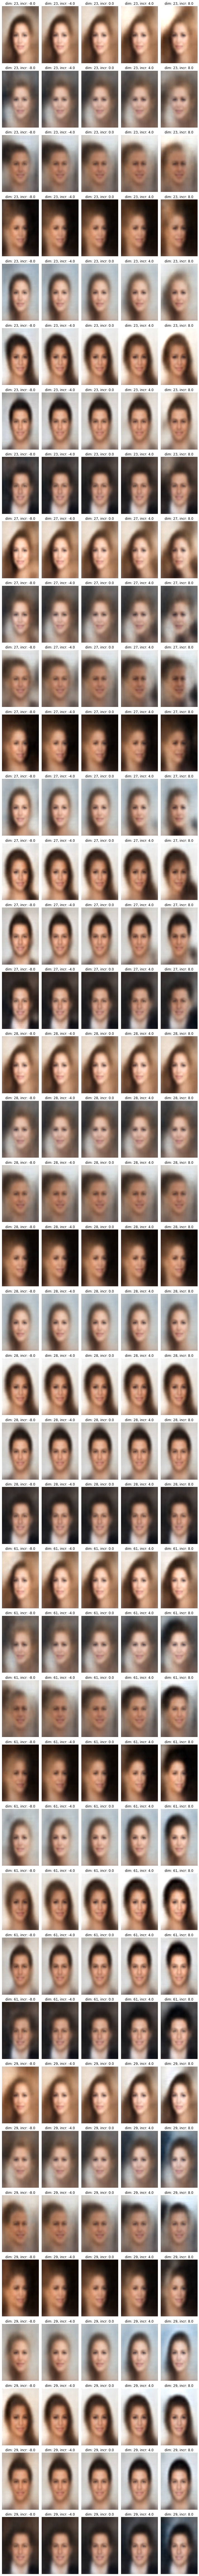

In [19]:
imnums = np.array([ 7015, 33, 634, 10015, 23, 2015, 25,10130])
relevant_dims = np.array([23, 27, 28, 61,  29 ]);
max_incr = 8.0
n_incrs = 5
f2, axarr2 = plt.subplots(len(relevant_dims)*len(imnums), n_incrs, figsize=(int(2.1*n_incrs), 2*64))

for idim, dim in enumerate(relevant_dims):
  for imnumi in range(len(imnums)):
    img = torch.Tensor(faces[imnumi:imnumi+1].astype('float16')).to(device)
    z0 = vae.encoder(img).cpu().detach().numpy()[0,:64]

    for iincr, incr in enumerate(np.linspace(-max_incr, max_incr, n_incrs)):
      increment = np.zeros((64,))
      increment[dim] = incr
      mu = torch.Tensor((z0 + increment).reshape(1, -1).astype('float16'))
      attrs = torch.Tensor(df.iloc[imnumi, 1:].to_numpy().reshape(1, -1).astype('float16'))
      h = torch.cat((mu, attrs), axis=1)
      img_mod = vae.decoder(h.to(device)).cpu().detach().numpy()
      img_mod = np.squeeze(np.moveaxis(img_mod, 1, -1)).clip(0.0, 1.0)
      axarr2[idim*len(imnums)+imnumi, iincr].imshow(img_mod, aspect='auto')
      axarr2[idim*len(imnums)+imnumi, iincr].set_title(f'dim: {dim}, incr: {incr}')
      axarr2[idim*len(imnums)+imnumi, iincr].axis('off')
      f2.tight_layout()